In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import quandl
import dill
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import matplotlib.pyplot as plt
from ipywidgets import interact

# Time Series
<!-- requirement: images/ts_xval.png -->
<!-- requirement: projects/timeseries-project -->
<!-- requirement: small_data/quandl_oil.pkl -->

Time series prediction or forecasting presents its own challenges which are different from machine-learning problems.  Like many other classes of problems, it also presents a number of special features which are common.

In general, while we could use regression to make predictions, the goal of time series analysis is to take advantage of the temporal nature of the data to make more sophisticated models. To properly forecast events, we need to implement techniques to find and model the long term trends (**drift**), periodic signals (**seasonality**), and residual noise in our data. We will also need to preserve the order of our observations while cross-validating our model.

We will follow this general procedure for modeling time series:
1. Plot the time series. Look for trends, seasonality, and step changes.
2. Model and remove drift and seasonal components. 
3. Fit a model to the residuals. 
4. Add drift and seasonality back into the model. 


## Trends in time series data

As we explain these, let's first define our time-series as

$$ \{X_t, t = \ldots, -1, 0, 1, \ldots\} \, . $$

We take $\varepsilon \sim N(0, \sigma^2)$ to be i.i.d. normal errors.  
1. **Stationarity**.  Informally, this means that the distribution of the $X_t$ is independent of time $t$.  Formally, a time-series is stationary if for all $k \ge 0$ and $t$, the following two $k$-tuples have the same distribution:
$$ (X_0,\ldots,X_k) \sim (X_t,\ldots,X_{t+k}) $$
1. **Drift**.  One reason a time-series might not be stationary is that it possess a drift.  For example, we know that prices tend to creep up with inflation.  Mathematically, we might represent the (log) prices as
$$ X_t = \mu t + \varepsilon_t $$
1. **Seasonality**.  Another reason a time-series might not be stationary is that it posseses a seasonal component.  For example, we know that the temperature increases in the summer and decreases in the winter.  A simple model of this might be
$$ X_t = \alpha \sin(\omega t) + \beta \cos(\omega t)$$

## Cross-validation for time series
Cross validation is very different for time series than with other machine-learning problem classes.  In normal machine-learning, we select a random subset of data as a validation set to estimate accuracy of your measure.  In time series, we have to consider the problem that we are trying to solve is often to predict a value in the future.  Therefore, the validation data always has to occur *after* the training data.  As a simple example, consider that it would not be very useful to have a predictor of tomorrow's temperature that depended on the temperature the day after. In general:

- We cannot just pick data points at random, because there might be lagged indicators / seasonal effects / etc. that force us to work with contiguous blocks of time.  
- We cannot blindly chop by e.g., month or year without some thought: There could be seasonal effects so that Decembers are always different.  There could be systemic "regime changes" that mean that cutting at a given date is inappropriate, or known and time-limited effects that last a year (or fraction thereof).   For instance, the years 1991 and 2008 in this data set.
- We cannot have our testing set occur before our training set.

![ts cross-validation illustration](images/ts_xval.png)

We usually handle this by doing a **sliding-window validation method**.  That is, we train on the last $n$ data points and validate the prediction on the next $m$ data points, sliding the $n + m$ training / validation window in time.  In this way, we can estimate the parameters of our model.  To test the validity of the model, we might use a block of data at the end of our time series which is reserved for testing the model with the learned parameters.

Another common technique is to use [**forward chaining**](http://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection).

**Question:** What are the strengths and weaknesses of using a fixed vs. rolling window?

## Modeling drift

For examples, we will use two different datasets, weather and oil prices. The weather data is available locally in the `projects/` subdirectory, and the oil data will be retrieved on-the-fly from Quandl.

In [3]:
# To really use the Quandl API, you should get an authtoken.  Limited usage doesn't require it.

authtoken = None
# authtoken = "your token here"

def get_quandl(what):
    """ 
    Wrapper around Quandl requests, using authtoken only if available
    """
    if authtoken:
        return quandl.get(what, authtoken=authtoken)
    else:
        return quandl.get(what)
    
#oil = get_quandl("DOE/RWTC")


In [ ]:
#with open('small_data/quandl_oil.pkl', 'wb') as f:
     #dill.dump(oil, f)  

In [4]:

with open("small_data/quandl_oil.pkl", "r") as fin:
    oil = dill.load(fin)


We will start of by visually inspecting our time series. 

In [5]:
oil.head()

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


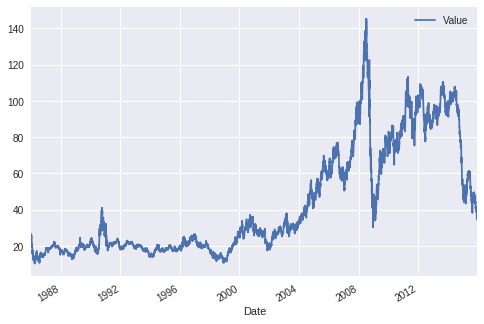

In [6]:
oil.plot()

Looking at the plot of oil value over time, we see that the trend is exponential. We can model exponential trends using a linear regression model if we transform the data first. 

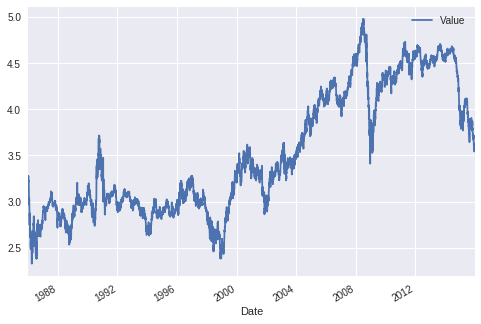

In [7]:
np.log(oil).plot()

In [8]:
# Add a constant field for the linear regression
def add_constant(X):
    X['const'] = pd.Series(np.ones(len(X.index)), index=X.index)
    return X

In [9]:
oil['Julian'] = oil.index.to_julian_date()
oil = add_constant(oil) 

# We can actually train a simple exponential model using the log(value), then train further models on the error.
exponential_model = sklearn.linear_model.Ridge().fit( 
    X=oil[['Julian', 'const']], 
    y=np.log(oil['Value'])
)

exp_model_df = oil
exp_model_df['Exponential_Model'] = np.exp(exponential_model.predict(oil[['Julian', 'const']]))
exp_model_df['Log_Error_Exponential'] = np.log(oil['Value'] / oil['Exponential_Model'])

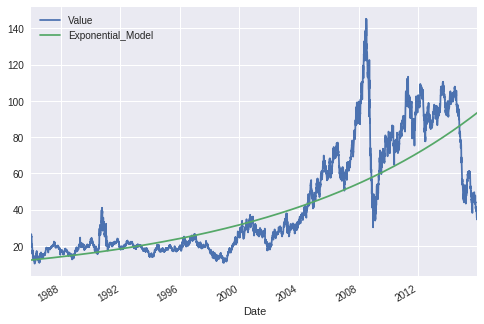

In [10]:
exp_model_df[['Value', 'Exponential_Model']].plot()

## Modeling seasonality

Let's take a look at the temperature dataset and see if we can spot any periodic signals. 

In [11]:
temps = pd.read_csv("projects/timeseries-project/data/raw/temperatures.csv", 
                    index_col=0,
                    names=["Temperature"],
                    parse_dates=True,
                    date_parser=lambda u: pd.datetime.strptime(u, "%Y-%m-%d %H:%M:%S"))

In [12]:
temps = temps.asfreq('60Min', method='ffill')
print temps[:3]

                     Temperature
2001-01-01 00:00:00           18
2001-01-01 01:00:00           18
2001-01-01 02:00:00           17


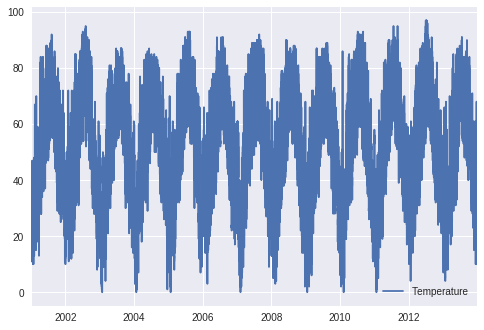

In [13]:
temps.plot()

We can clearly see that there is seasonality in our temperature data. In order to model or remove these signals from our time series, we need to determine their amplitudes and frequencies. Since we are all familiar with daily and yearly temperature swings, we can probably guess what those frequencies are. However, there is a formal approach we can take to find these frequencies. 

### Fourier Analysis

Any ** periodic signal** can be represented as the sum of a number of sine waves with varying amplitude, phase, and frequency.  A time series can be convered into its frequency components with the mathematical tool known as the *Fourier transform*.  As we are dealing with sampled data, we must use the discrete version.  

For $N$ uniformly sampled datapoints $x_j$ ($j = 0$,...,$N-1$)

$$ x_j = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{i2 \pi jk/N} $$
$$ X_k = \sum_{j=0}^{N-1} x_j e^{-i2 \pi jk/N} $$

The common algorithm for computing discrete transforms in the *fast Fourier transform*, usually abbreviated *FFT*.

The output of a FFT can be thought of as a representation of all the frequency components of your data. In some sense it is a histogram with each “frequency bin” corresponding to a particular frequency in your signal. Each frequency component has both an amplitude and phase, and is represented as a complex number. In the equations above, $X_k$ can be thought of as the "ammount" of frequency $k$ in the signal $x$. Generally, we care only about the amplitude, given by the modulus of that complex term.  As we are dealing with discrete data, the signal is bounded, and interpretation of the axes requires some consideration.

For our purposes, it's enough to know that any strong signals such as peaks in the frequency domain represent some periodic (sinusoidal) behavior in the time domain. You can then go through the process of determining the wavelength (periodicity) based on how the FFT was taken.

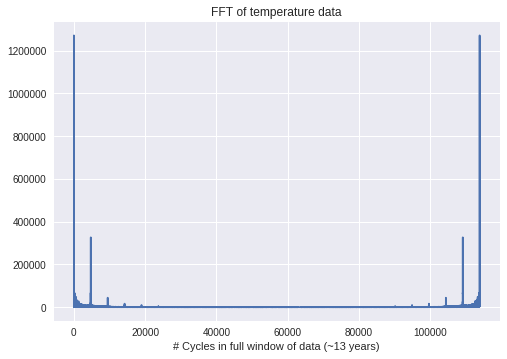

In [14]:
from scipy import fftpack

fft = fftpack.fft(temps.Temperature - temps.Temperature.mean())
plt.plot(np.abs(fft))
plt.title("FFT of temperature data")
plt.xlabel('# Cycles in full window of data (~13 years)')

Note that we subtract the mean before computing the FFT.  Otherwise, there would be a large zero-frequency component.

The x-axis is showing frequency.  Low frequencies, corresponding to long times, are on the left; high freqencies and short times are on the right.  The lowest non-zero frequency measured has a single cycle over the full 13-year period, corresponding to a frequency of $1/13\, y^{-1}$.  The highest frequency is that of the sampling, $1\, h^{-1}$.

The discrete Fourier transform of real data is symmetric about the center of its frequency range.  Due to the problem of *aliasing*, it cannot distinguish signals with a frequency above half its sampling frequency from those below.  This limiting frequency is called the **Nyquist frequency**, and the results of a FFT for frequencies above it should be ignored.

More formally, the Nyquist frequency is the highest frequency that can be resolved given your sampling rate.

$$ \nu_N = \frac{1}{2 \Delta t} $$

The following plot demonstrates that, with a sampling frequency of 1, it is impossible to distinguish between signals above and below the Nyquist frequency of 0.5.

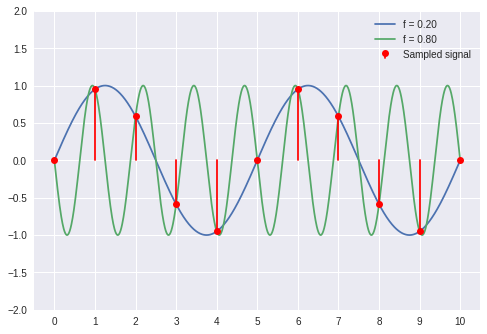

In [15]:
def plot_alias(f=0.2):
    t = np.linspace(0, 10, 1000)
    ts = np.arange(0, 11)
    plt.plot(t, np.sin(2*np.pi * f * t), label='f = %0.2f' % f)
    plt.plot(t, -np.sin(2*np.pi * (1 - f) * t), label='f = %0.2f' % (1 - f))
    ml, sl, bl = plt.stem(ts, np.sin(2*np.pi * f * ts), label='Sampled signal')
    plt.setp(ml, 'markerfacecolor', 'r')
    plt.setp(sl, 'color', 'r')
    plt.setp(bl, visible=False)
    plt.xticks(ts)
    plt.ylim(-2,2)
    plt.legend()

interact(plot_alias, f=(0,0.5,0.05))

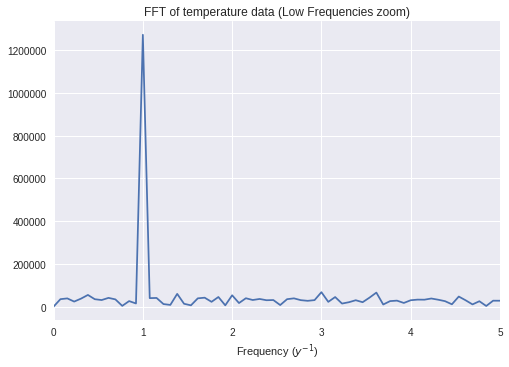

In [16]:
plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)')

**Question:** Is the above showing the yearly or daily seasonality?

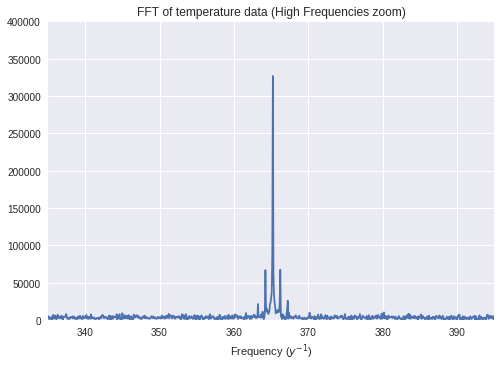

In [17]:
daily_cycles_in_13_years = 13*365

plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (High Frequencies zoom)")
plt.ylim([0,400000])
plt.xlim([365 - 30, 365 + 30])
plt.xlabel('Frequency ($y^{-1}$)')

**Question:** What do you expect the FFT of the oil data to look like?

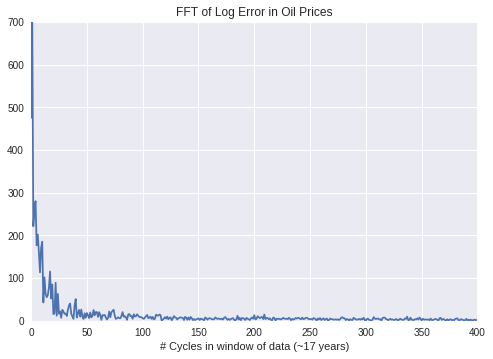

In [18]:
fft = fftpack.fft(oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2010)])
plt.plot(np.abs(fft))
plt.ylim([0, 700])
plt.xlim([0, 400])
plt.title('FFT of Log Error in Oil Prices')
plt.xlabel('# Cycles in window of data (~17 years)')

There are two ways to handle seasonality.  Seasonality features are nice because they are good at projecting arbitrarily far into the future.

1. The simplest (and perhaps most robust) is to have a set of indicator variables for each month.

  **Question**: Should month be a continuous or categorical variable?

1. Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be
$$ y_t = k \sin\left( \frac{t - t_0}{T} \right) + \epsilon$$
where $k$ and $t_0$ are parameters to be learned and $T$ is one year for seasonal variation.  While this is linear in $k$, it is not linear in $t_0$.  However, we know from Fourier analysis, that the above is equivalent to 
$$ y_t = A \sin\left( \frac{t}{T} \right) + B \cos\left( \frac{t}{T} \right) + \epsilon$$
which is linear in $A$ and $B$.  This can be solved using a linear regression.

**Question:** Does it always make sense to combine seasonal frequencies additively? When would it not?

### Example: Temperature data

In [19]:
temps['Julian'] = temps.index.to_julian_date()
temps['const'] = 1
temps['sin(year)'] = np.sin(temps['Julian'] / 365.25 * 2 * np.pi)
temps['cos(year)'] = np.cos(temps['Julian'] / 365.25 * 2 * np.pi)
temps['sin(6mo)'] = np.sin(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['cos(6mo)'] = np.cos(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['sin(day)'] = np.sin(temps.index.hour / 24.0 * 2* np.pi)
temps['cos(day)'] = np.cos(temps.index.hour / 24.0 * 2* np.pi)

In [20]:
temps['Temperature'].head()

2001-01-01 00:00:00    18
2001-01-01 01:00:00    18
2001-01-01 02:00:00    17
2001-01-01 03:00:00    20
2001-01-01 04:00:00    21
Freq: 60T, Name: Temperature, dtype: int64

In [21]:
temps['Temperature'].shift(-1).head()

2001-01-01 00:00:00    18.0
2001-01-01 01:00:00    17.0
2001-01-01 02:00:00    20.0
2001-01-01 03:00:00    21.0
2001-01-01 04:00:00    21.0
Freq: 60T, Name: Temperature, dtype: float64

In [22]:
# notice that the goal is our variable shifted by the desired period of time
temps['Goal'] = temps['Temperature'].shift(-24)

60.4611669265


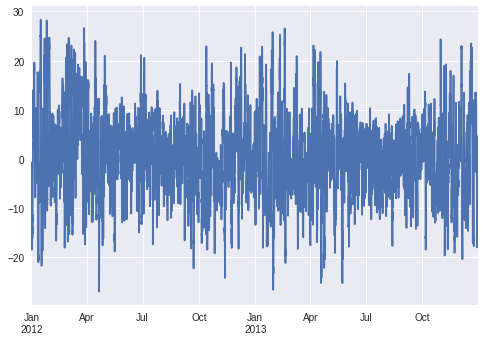

In [23]:
cut_year = 2012

train = temps[temps.index.year < cut_year].dropna(how='any')
test  = temps[temps.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict(X=test[['Temperature', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value'])

To remove these frequencies, you can apply a filter to your time series. Filters are discussed in further detail in the digital signals notebook. You can also check out [this](http://stackoverflow.com/questions/39799821/how-to-remove-frequency-from-signal) stack overflow post. 

## Modeling "noise"

We can improve our temperature predictions by modeling the noise. In this context, the noise is caused by weather patterns that are superimposed on the background climatology. If you are trying to predict the temperature a few hours into the future (what is known as _nowcasting_), you can imagine that the weather from two months ago is not as good of an indicator as the weather from three hours ago. How far back in your time series should you look? You can autocorrelate your time series (with drift and seasonality removed) to find out.

### Autocorrelation

Let's review some definitions:

* **Covariance** ($s_{xy}$)

$$ \mbox{Cov}(X,Y) = E[(X - E(X))(Y - E(Y))] = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y}) $$

* **Variance** ($s_x^2$) is equal to Cov(X,X).

$$ \mbox{Var}(X) = E[(X - E(X))^2] = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})^2 $$

* **Standard Deviation** ($s_x$) is the square root of the variance. 
* **Correlation** ($\rho$)

$$ \mbox{Cor}(X,Y) = \frac{s_{xy}}{s_x s_y} $$

If we replace time series Y with a laged version of X, we can compute the autocovariance and autocorrelation of X at that given lag, $k$. 

* **Autocovariance**

$$ \gamma_k = \mbox{Cov}(X_t, X_{t+k}) $$

* **Autocorrelation**

$$ \rho_k = \frac{\gamma_k}{\gamma_0} = \frac{\gamma_k}{s_x^2}$$

**Question**: The definitions above apply to data sampled from some parent population. How do the equations change if you consider the entire population?

It is useful to plot the autocorrelation for different values of $k$. Pandas includes a function which will create an autocorrelation plot for any data series.  It includes lines showing the 95% (solid) and 99% (dashed) confidence levels of the zero-correlation hypothesis. Let's look at this plot for the oil data.

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


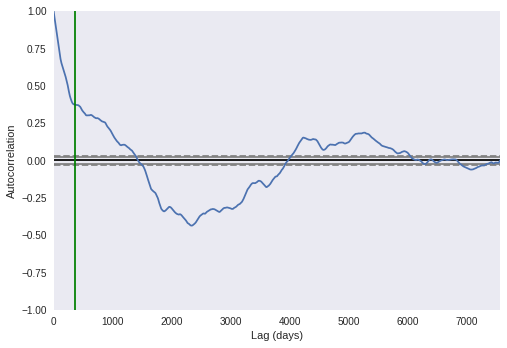

In [24]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(oil['Log_Error_Exponential'])
plt.xlabel('Lag (days)')
plt.axvline(365, color = 'green')

Notice that the autocorrelation is one at zero lag. This will be true for every time series. Why? Also notice that the autocorrelation drops to zero at around 1500 days. We have discovered that if we want to predict future oil values, we should only consider "noise" up until 1500 days prior. The time associated with this zero crossing is called the characteristic time scale. 

### Moving Average

Once we know how closely points in the time series are correlated with recent points, we can predict arbitrarily far into the future by substituting the moving average predictions in for values as necessary. For example, if we only knew the values up through time x, we would need to estimate Value[x + 1] before calculating Value[x + 2] = f(Value[x + 1], Value[x], Value[x - 1], ...).

There are many types of [moving average](http://en.wikipedia.org/wiki/Moving_average). Simple variations on this include [exponential moving averages](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) and [rolling window averages](https://en.wikipedia.org/wiki/Moving_average#Cumulative_moving_average). While these features might give more accurate data, they are only useful for short-term projections (as compared to seasonality and longer-term trends). As you'll see, they're also quite good for smoothing purposes. We will be computing the exponentially weighted moving average here:

$$E_t = \alpha X_t + (1-\alpha)E_{t-1}$$

Note that as the smoothing factor $\alpha$ increases, older observations are discounted faster. In Pandas, the ewm() method allows for specifying the decay as a function of $\alpha$ in three ways:
1. The center of mass (*com*), giving $\alpha = \frac{1}{1 + com}$
2. The *span*, giving $\alpha = \frac{2}{1 + span}$
3. The *halflife*, giving $\alpha = 1 - \exp{\frac{\log(0.5)}{halflife}}$

### Example: Predicting Oil Prices

Let's pick up the oil price data using the residual after the exponential trend is removed. Since we know that something crazy happened in 2008 (financial meltdown) and something else crazy happened in 1992 (Iraq War), we'll restrict our analysis to between those two dates. We will attempt to build a model to predict oil prices 3 months in the future.  A column of oil prices shifted by in time by 3 months will serve as our labels for testing and training.

In [25]:
## Create a column with "true" (future) values
PERIOD_MONTH = 20
PREDICTION_LAG = 3 * PERIOD_MONTH

CUT_YEAR = 2008

# notice that the goal is our variable shifted by the desired period of time
oil['Actual'] = oil['Value'].shift(-PREDICTION_LAG)

In [26]:
oil['Value'].head()

Date
1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
Name: Value, dtype: float64

In [27]:
oil['Value'].shift(-1).head()

Date
1986-01-02    26.00
1986-01-03    26.53
1986-01-06    25.85
1986-01-07    25.87
1986-01-08    26.03
Name: Value, dtype: float64

In [28]:
oil.head()

,Value,Julian,const,Exponential_Model,Log_Error_Exponential,Actual
Date,,,,,,
1986-01-02,25.56,2446432.5,1.0,12.254436,0.735141,10.25
1986-01-03,26.00,2446433.5,1.0,12.256711,0.752023,11.13
1986-01-06,26.53,2446436.5,1.0,12.263539,0.771646,11.35
1986-01-07,25.85,2446437.5,1.0,12.265816,0.745494,11.70
1986-01-08,25.87,2446438.5,1.0,12.268093,0.746082,12.75


We build a model to predict the residuals of the exponential model three months out, from the last and current residuals, as well as 3-month rolling averages for the price and its derivative.

count    1899.000000
mean       -0.033600
std         0.270578
min        -2.225409
25%        -0.090917
50%         0.041134
75%         0.119519
max         0.442401
dtype: float64


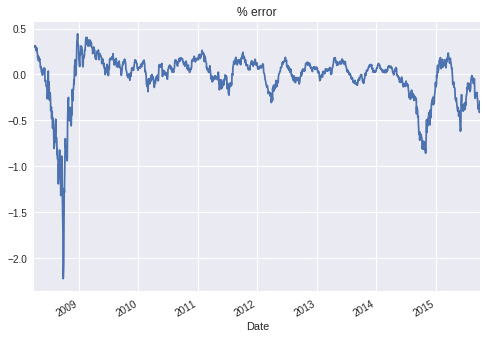

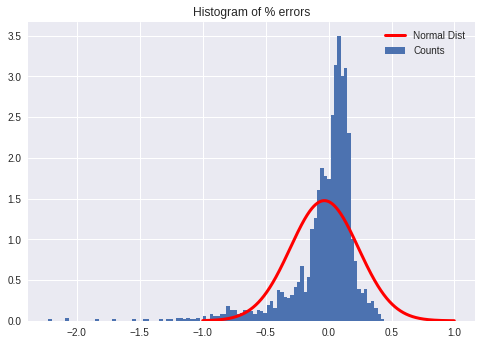

240.960319772


In [29]:
### Cross validation -- simple model

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]

# Reporting function
def summarize_errors(test_me):
    error_pct = (test_me['Actual'] - test_me['Model']) / test_me['Actual']

    print error_pct.describe()
    error_pct.plot()
    plt.title('% error')
    plt.show()

    error_pct.hist(bins=100, normed=True, label = 'Counts')
    x = np.arange(-1, 1, 0.001)
    plt.plot(x, sp.stats.norm(loc=error_pct.mean(),
                              scale=error_pct.std()).pdf(x),
                              linewidth=3, color='red', label='Normal Dist')
    plt.title('Histogram of % errors')
    plt.legend()
    plt.show()

    print sklearn.metrics.mean_squared_error( test_me['Actual'], test_me['Model'] )

# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    # real data / exponential fit
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['LEE_1'] = frame['Log_Error_Exponential'].shift(1)
    feats['dLEE_avg'] = pd.Series.rolling(frame['Value'].diff(), window=3*PERIOD_MONTH).mean()
    feats['vol_avg'] = pd.Series.ewm(frame['Value'], span=3*PERIOD_MONTH).var(bias=False)
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return add_constant(feats)

feats = frame_to_feats(train).dropna(how='any')
X_train = feats.drop('Actual_LEE', axis=1).values
y_train = feats['Actual_LEE'].values
regress = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

# Predict
feats = frame_to_feats(test).dropna(how='any')
X_test = feats.drop('Actual_LEE', axis=1).values
y_test = feats['Actual_LEE'].values
feats['Predicted_LEE'] = regress.predict(X_test)

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Simple_Model'] = np.exp(test['Predicted_LEE']) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Simple_Model']].dropna(how='any') \
                                          .rename(columns={'Simple_Model': 'Model'})
summarize_errors(test_me)

**Exercise**: Build a temperature predictor using just these other features.  Try experimenting with non-linear models like random forests as well as linear ones.  While it may not be as effective, it can add signal when combined with the above models.  *Notes*:
1. Make sure you don't accidently give yourself access to concurrent data: you cannot use the wind direction this hour to predict the temperature, you have to use past wind direction information.
1. Try combining the signal using non-linear as well as linear techniques.  Is there a reason you might think that linear techniques work pretty well for aggregation of different signals?

## Using external data sources as features

So far, our features have all depended on the date and previous temperature.  However, we can add in other variables into our prediction. Ideally we'd like to find signal in additional data sources that accounts for some of the error; to try to conceptually explain sources of error or skews in the distribution of error; etc.  Here are examples of other data sources we might try:

  - Other financial indicators (e.g., interest rates, volatilities, related commodities)
  - Non-financial indicators (e.g., weather, indicators for weather patterns / wars, geopolitical data like gdelt).
  
We'll show the example of trying to use equities volatility data (in the form of the VIX index) -- note that this will not help. Can you do better?

In [30]:
ng_fut = get_quandl("CHRIS/CME_NG1")
vix = get_quandl("YAHOO/INDEX_VIX")

oil['vix'] = vix['Adjusted Close']
oil['ng_fut'] = ng_fut['Settle']

NotFoundError: (Status 404) (Quandl Error QECx02) You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.

In [ ]:
# Looking at linear correlations between new data and the stationary residual of the oil data
print oil['Log_Error_Exponential'].corr(oil['vix'])  # Our error term does correlate negatively with vix...
print oil['Log_Error_Exponential'].corr(oil['ng_fut'])

oil['vix'].plot()
plt.show()

oil['ng_fut'].plot()
plt.show()

In [ ]:
### Cross validation -- complex model -- notice that we have overfit!

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]


# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['dLEE_avg'] = pd.Series.rolling(frame['Value'].diff(), window=3*PERIOD_MONTH).mean()
    feats['vol_avg'] = pd.Series.ewm(frame['Value'], span=3*PERIOD_MONTH).var(bias=False)
    
    feats['ng_fut'] = frame['ng_fut']
    feats['vix'] = frame['vix']
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return add_constant(feats)
    

feats = frame_to_feats(train).dropna(how='any')
regress = sklearn.linear_model.LinearRegression().fit( 
        X=feats.drop('Actual_LEE', axis=1), 
        y=feats['Actual_LEE'])

# Predict

feats = frame_to_feats(test).dropna(how='any')
feats['Predicted_LEE'] = regress.predict(feats.drop('Actual_LEE', axis=1))

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Complex_Model'] = np.exp (test['Predicted_LEE']) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Complex_Model']].dropna(how='any') \
                                           .rename(columns = {'Complex_Model': 'Model'})
summarize_errors(test_me)

### Open-ended brainstorming / exercises

1. What happens to the results above if we change our "cut point" to say 2010?  What's the moral of this story...

2. Play around with the previous "Complex" model, and see if you can improve it.  What happens, for instance, if you get rid of the 'vix' signal.  Why do you think this might be the case?

3. What are some other "simplest" models we could have tried? e .g., linear regression just on 'Value' rather than going through this log stuff.  Try some of them -- how do they perform?

4. Carry out a similar analysis for the temperature data.

## More advanced time series modeling frameworks

If a time series can be made stationary (trendless) by differencing or by the methods above, it is common to model it using some combination of auto-regressive terms (weighted average over some recent values) and moving average terms (weighted average over some recent errors) of different orders. The number of terms can be determined through various methods and rules of thumb. [Read more.](http://people.duke.edu/~rnau/411arim.htm)

There is an entire literature on [auto-regressive models](https://en.wikipedia.org/wiki/Autoregressive_model) as well as [auto-regressive moving average models](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model).  Read up about them on wikipedia to get a better idea.  In python, they are implemented in [Statsmodels](https://github.com/statsmodels/statsmodels/).

* **Moving Average (MA) model**. This model works under the assumption that the output variable depends linearly on the current and past values of noise. 
$$ X_t = \mu + \varepsilon_t + \sum_{s=1}^q \theta_s \varepsilon_{t-s} $$

Here, $\mu$ is the mean of the time series, the $\varepsilon$'s are the noise, and the $\theta$'s are the model parameters. We choose $q$ based on the where the autocorrelation function of MA($q$) becomes zero at lag $q+1$. We can fit the model parameters $\theta$ using least squares regression or maximum likelihood estimation. 

* **Auto-regressive Model (AR)**.  Informally, auto-regressive processes "regress to the mean".  This model works under the assumption that the output depends linearly on the previous values and a stochastic term. 

$$ X_t = c + \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t $$

Here, $c$ is a constant and the $\varphi$'s are the model parameters. The parameters can be found using least squares regression, maximum likelihood estimation, or the autocorrelation function:

$$ \rho(\tau) = \sum_{s=1}^p \varphi_s \rho(s - \tau) $$
  
* **ARMA**.  This is just a combination of auto-regressive and moving average structures.  An $ARMA(p,q)$ process is given by the equations
$$ X_t = \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t + \sum_{s=1}^q \theta_s \varepsilon_{t-s} $$
Because we like mathematical shorthand, we will define a "lag operator" as
$$ L(X)_t = X_{t-1} $$
so that $L^2(X)_t = X_{t-2}$, etc ...
Then we can rewrite the ARMA equation in terms of the lag operator as
$$ \varphi(L) X = \theta(L) \epsilon $$
where the polynomials are given by 
$$\varphi(z) = 1-\sum_{r=1}^p \varphi_r z^r$$
and
$$\theta(z) = 1+\sum_{s=1}^q\theta_s z^s \, .$$  It turns out this fancy notation will be useful later on. You can use a 2-step regression to estimate the model parameters. Alternatively you can use maximum likelihood estimation or Yule-Walker estimation. 

* **ARIMA**.  While ARMA is useful for handling stationary processes, it does not handle non-stationary proesses well.  Sometimes we can remove drift and seasonality directly, especially when there is a clear physical interpretation.  Othertimes, it is easier to just do so automatically by "differentiating".  We'll define the operator $\nabla= (1-L)$ so that
$$ (\nabla X)_t = X_t - X_{t-1} $$
Notice that
$$ (\nabla^2 X)_t = (1-L)^2  X_t = (1-2L+L^2)X_t = X_t - 2X_{t-1} + X_{t-2}. $$
$ARIMA(p, d, q)$ is just $ARMA(p,q)$ applied to $(\nabla^d X)_t$.  In our operator notation
$$ (\varphi \circ \nabla^d) (L) X = \theta (L) \varepsilon\,. $$
Notice that we can just rewrite $\varphi' = \varphi \circ \nabla^d$ as
$$ \varphi'(z) = 1- \sum_{r=1}^{p+d} \varphi'_r z^r = \left(1-\sum_{r=1}^p \varphi_r z^r\right) (1-z)^d $$
and so we have that $ARIMA(p, d, q)$ is (basically) just an $ARMA(p+d,q)$.

**Exercise**: Write a *residual regressor* that takes your best model and tries to fit and AR or ARMA model on the residuals using Statsmodels.  *Notes:*
1.  We should always first remove seasonality and "last data point" features (the low-hanging fruit) before trying to perform analysis on the residuals.
1.  It is not always natural to fit statsmodels into the framework
1.  While the previous models could be tested by training models on the entire training set and then validating, for these autocorrelation models, we have to use sliding-window validation method mentioned above.

### Stochastic auto-regressive models

Our time series has, very cleary, time-varying volatility.  To accurately model these effects, one often uses stochastic models.  To start you Googling, the basic auto-regressive examples are **ARCH/GARCH**.  

Let us say just a little about these, leaving an example as an exercise to the reader.  In this type of model, the next time tick's value is drawn from a _distribution_ whose mean **and** standard deviation are modelled over time (and can, in general, be auto-regressive):

$$ t_{i+1} = M(\text{..factors..}) + \sigma(\text{..factors..}) \epsilon_t $$

where 
  - $M$ is some model for the mean (e.g., a linear model depending on some number of time lags of $t_{i}$ and moving averages in GARCH models);
  - $\sigma$ is some model for the standard deviation (as above in GARCH);
  - and, $\epsilon_t$ is a draw from a distribution having (conditional on the factors..) mean equal to zero, and standard deviation equal to one.  (In ARCH, this is a normal distribution.)
  
Stochastic models allow us to generate a range of future paths, for instance for modelling "value at risk."

### Exit Tickets
1. Describe how you would cross-validate a time series model.
1. Describe the difference between auto-regressive and moving average terms in an ARMA model.
1. Explain an FFT to a layperson.

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*